# Classical Sentiment Analysis

Develop a classical machine-learning-based sentiment classifier for movie reviews. The dataset contains a collection of annotated documents, which are divided into two classes: **pos** (positive) and **neg** (negative).

Our goal is to achieve the best macro-average `F1-score` using classical machine-learning approaches such as `Naïve Bayes`, `Logistic Regression`, and `Random Forests`.

[![Report](https://img.shields.io/badge/Full_Report_in_W&B-gray?logo=weightsandbiases&logoColor=yellow)](https://api.wandb.ai/links/research-devellopment/hjgmo1ka)


## Import Dependencies

In [1]:
import os
import pathlib
import re
from warnings import filterwarnings
from collections import Counter
from dataclasses import dataclass, field
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import BaseEstimator
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score, log_loss, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import wandb
filterwarnings("ignore")

In [2]:
!wandb login

wandb: Currently logged in as: ismaelmousa (research-devellopment) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


## Construct Configurations and Pipelines
- Dataset Configuration
- Model Configuration
- Dataset Handler
- Model Wrapper

### Dataset Configuration

- Manages dataset paths, labels, and NLP settings.
- Key Attributes:
  - `negatives`/`positives`: Paths to labeled data directories.
  - `labels_to_ids`: Maps `"neg"`/`"pos"` to numerical IDs.
  - `stopwords`: Combined set (`ENGLISH_STOP_WORDS` + NLTK stopwords).
  - `negations`: Predefined negation phrases (e.g., `"not"`, `"don't"`).

In [52]:
@dataclass
class DatasetConfig:
    """
    Represents the dataset configuration for managing dataset paths and related settings.
    Encapsulating various configurations related to dataset paths, file locations,
    and other properties necessary for working with a dataset in a training or evaluation context.

    type: The type of the dataset (e.g., `training`, `testing`).
    root: The root directory of the project.
    data: The path to the data directory.
    dataset: The path to the dataset directory, based on the dataset type.
    negatives: The path to the directory containing negative samples (labeled `neg`).
    positives: The path to the directory containing positive samples (labeled `pos`).
    num_negatives: The number of negative samples in the `neg` directory.
    num_positives: The number of positive samples in the `pos` directory.
    labels_to_ids: A mapping of label names (`neg` and `pos`) to corresponding numerical IDs.
    ids_to_labels: A mapping of numerical IDs to corresponding label names.
    stopwords: A set of stopwords from `ENGLISH_STOP_WORDS` and `stopwords.words("english")`.
    negations: A set of negation words or phrases commonly used in natural language processing.
    """
    type: str = "training"
    root: str = os.getcwd()
    data: str = field(init=False)
    dataset: str = field(init=False)
    negatives: pathlib.Path = field(init=False)
    positives: pathlib.Path = field(init=False)
    num_negatives: int = field(init=False)
    num_positives: int = field(init=False)
    labels_to_ids: dict = field(default_factory=lambda: {"neg": 0, "pos": 1})
    ids_to_labels: dict = field(default_factory=lambda: {0: "neg", 1: "pos"})
    stopwords: set = field(default_factory=lambda: set(ENGLISH_STOP_WORDS) | set(stopwords.words("english")))
    negations: set = field(default_factory=lambda: {"not", "don't", "don", "aren", "ain", "aren't",
                                                     "couldn", "couldn't", "didn", "didn't", "doesn",
                                                     "doesn't", "hadn", "hadn't", "hasn", "hasn't",
                                                     "haven", "haven't", "isn", "isn't", "ma", "mightn",
                                                     "mightn't", "mustn", "mustn't", "needn", "needn't",
                                                     "shan", "shan't", "shouldn", "shouldn't", "wasn",
                                                     "wasn't", "weren", "weren't", "won't", "wouldn",
                                                     "wouldn't", "no", "never", "none", "nothing",
                                                     "nobody", "nowhere", "neither", "nor", "cannot",
                                                     "can't", "couldn't", "less", "without", "hasn't",
                                                     "noone", "nevertheless", "otherwise"})

    def __post_init__(self):
        self.data = os.path.join(self.root, "data")
        self.dataset = os.path.join(self.data, f"{self.type}_data")
        self.negatives = pathlib.Path(os.path.join(self.dataset, "neg"))
        self.positives = pathlib.Path(os.path.join(self.dataset, "pos"))
        self.num_negatives = len(os.listdir(self.negatives)) if self.negatives.exists() else 0
        self.num_positives = len(os.listdir(self.positives)) if self.positives.exists() else 0

### Construct Dataset's Utilities

Implements the `Dataset` class handler, where handles loading the data, analyzing, splitting, cleaning and preprocessing it.

In [4]:
class Dataset:
    """
    A dataset handler for text classification tasks.

    This class is responsible for loading, processing, and splitting labeled text datasets.
    It provides various text preprocessing utilities, including stopword removal,
    lemmatization, negation normalization, and HTML tag removal.

    config: An instance of DatasetConfig containing dataset configurations.
    read: A DataFrame storing the loaded dataset with "text" and "label" columns.
    """
    def __init__(self, config: DatasetConfig):
        self.config = config
        self.read = None


    def load(self):
        """
        Loads the dataset into a DataFrame.

        Reads text files from positive and negative directories, assigns labels, and stores
        the dataset as a DataFrame with "text" and "label" columns.

        :return: A DataFrame containing the loaded dataset.
        """
        if self.read is not None: return self.read

        directories = {"neg": self.config.negatives, "pos": self.config.positives}

        text_label = [(file.read_text(), label)
                      for label, directory in directories.items()
                      for file in directory.iterdir()]

        self.read = pd.DataFrame(text_label, columns=["text", "label"])

        return self.read


    def count(self, n):
        """
        Finds the most common words in positive and negative texts.

        Extracts the most frequent words from negative and positive samples, identifies
        common words between the two categories, and lists words unique to each category.

        :param n: The number of top words to retrieve.
        :return: A tuple containing:
                 - list of top negative words
                 - list of top positive words
                 - list of words common in both categories
                 - set of words unique to negatives
                 - set of words unique to positives
        """
        if self.read is None: return "First: Dataset().load()"

        if isinstance(self.read["label"].iloc[0], str):
            negatives = " ".join(self.read[self.read["label"] == "neg"]["text"]).lower()
            positives = " ".join(self.read[self.read["label"] == "pos"]["text"]).lower()

        else:
            negatives = " ".join(self.read[self.read["label"] == 0]["text"]).lower()
            positives = " ".join(self.read[self.read["label"] == 1]["text"]).lower()

        top_negatives = [word for word, _ in Counter(negatives.split()).most_common(n)]
        top_positives = [word for word, _ in Counter(positives.split()).most_common(n)]

        commons = list(set(top_negatives) & set(top_positives))

        only_negatives = set(top_negatives) - set(top_positives)
        only_positives = set(top_positives) - set(top_negatives)

        return top_negatives, top_positives, commons, only_negatives, only_positives


    def info(self, n=10):
        """
        Displays dataset statistics and common words.

        Prints the number of positive and negative samples, calculates the average word count per category,
        and visualizes the results. Also lists the most common words found in each category.

        :param n: The number of top words to display.
        """
        if self.read is None: return "First: Dataset().load()"

        print("Negatives: ", self.config.num_negatives)
        print("Positives: ", self.config.num_positives)

        if isinstance(self.read["label"].iloc[0], str):
            flag = "Before Cleaning"
            color = "red"
            negatives = self.read[self.read.label=="neg"].text.apply(lambda text: len(text.split())).mean()
            positives = self.read[self.read.label=="pos"].text.apply(lambda text: len(text.split())).mean()

        else:
            flag = "After Cleaning"
            color = "blue"
            negatives = self.read[self.read.label==0].text.apply(lambda text: len(text.split())).mean()
            positives = self.read[self.read.label==1].text.apply(lambda text: len(text.split())).mean()

        top_negatives, top_positives, commons, only_negatives, only_positives = self.count(n=n)

        print(f"\nCommon {n} Words {flag}:")
        print(f"\nNegatives          : {top_negatives}")
        print(f"\nPositives          : {top_positives}")
        print(f"\nCommons (neg & pos): {commons}")
        print(f"\nOnly Negatives     : {only_negatives}")
        print(f"\nOnly Positives     : {only_positives}")


        plt.figure(figsize=(10, 3))
        plt.barh(["Negative", "Positive"], [negatives, positives],height=0.5, color=color)
        plt.xlabel(f"Average Number of Words {flag}")
        plt.ylabel("Label")
        plt.show()


    def split(self):
        """
        Splits the dataset into train and test sets.

        :return: A tuple (train_inputs, test_inputs, train_labels, test_labels).
        """
        if self.read is None: return "First: Dataset().load()"

        inputs = self.read["text"]
        target = self.read["label"]

        return train_test_split(inputs, target, test_size=0.2, random_state=42, stratify=target)


    @staticmethod
    def lemmatize(tokens):
        """
        Lemmatizes a list of tokens.

        :param tokens: A list of word tokens.
        :return: A list of lemmatized tokens.
        """
        lemmatizer = WordNetLemmatizer()
        text = [lemmatizer.lemmatize(token.lower()) for token in tokens]
        text = [lemmatizer.lemmatize(token.lower(), "v") for  token in text]

        return text


    @staticmethod
    def normalize_negations(text):
        """
        Normalizes negations by replacing contractions with their full form.

        :param text: A string of text.
        :return: The modified text with normalized negations.
        """
        return re.compile("n't ").sub(" not ", text)


    @staticmethod
    def remove_html_tags(text):
        """
        Removes HTML tags from a string.

        :param text: A string containing potential HTML tags.
        :return: Cleaned text without HTML elements.
        """
        return BeautifulSoup(text, "html.parser").get_text()


    @staticmethod
    def remove_non_alphanumeric(text):
        """
        Removes non-alphanumeric characters from a string.

        :param text: A string of text.
        :return: Cleaned text containing only letters and numbers.
        """
        return re.sub("[^a-zA-Z_0-9]", " ", text)


    @staticmethod
    def lowercase(text):
        """
        Converts a string to lowercase.

        :param text: A string of text.
        :return: A lowercase version of the input text.
        """
        return np.char.lower(text.split())


    def remove_stopwords(self, text):
        """
        Removes stopwords from a list of tokens.

        :param text: A list of word tokens.
        :return: A list of tokens without stopwords.
        """
        stopwords = self.config.stopwords - self.config.negations

        return [token for token in text if not token in stopwords]


    def clean(self):
        """
        Applies a sequence of text cleaning steps.

        Removes HTML tags, normalizes negations, removes non-alphanumeric characters,
        lowercases the text, removes stopwords, lemmatizes words, and converts tokens back into a string.
        Updates labels to their numerical format.

        :return: A cleaned DataFrame.
        """
        if self.read is None: return "First: Dataset().load()"

        self.read["text"] = self.read["text"].apply(self.remove_html_tags)
        self.read["text"] = self.read["text"].apply(self.normalize_negations)
        self.read["text"] = self.read["text"].apply(self.remove_non_alphanumeric)
        self.read["text"] = self.read["text"].apply(self.lowercase)
        self.read["text"] = self.read["text"].apply(self.remove_stopwords)
        self.read["text"] = self.read["text"].apply(self.lemmatize)
        self.read["text"] = self.read["text"].apply(lambda tokens: " ".join(tokens))

        self.read["label"] = self.read["label"].map(self.config.labels_to_ids)

        return self.read

### Model Configuration

Defines the `ModelConfig` class to manage machine learning model settings, including hyperparameters for the classifier (e.g., MultinomialNB) and vectorizer (TfidfVectorizer).

Initializes components during post-initialization.

In [5]:
@dataclass
class ModelConfig:
    """
    Represents the configuration for machine learning model and vectorizer.
    Managing hyperparameters and initialization of the model and vectorizer.

    model_params: Hyperparameters for the model.
    model: The initialized machine learning model, default MultinomialNB.
    vectorizer_params: Hyperparameters for the vectorizer.
    vectorizer: The initialized TF-IDF vectorizer.
    results: A list to store experiment results and configurations.
    experiments: The experiment number, mainly used for logging.
    """
    model_params: dict = field(default_factory=lambda: {})
    model: BaseEstimator = field(init=False)
    vectorizer_params: dict = field(default_factory=lambda: {})
    vectorizer: TfidfVectorizer = field(init=False)
    results: list = field(default_factory=lambda: [])
    experiments: int = 1

    def __post_init__(self):
        self.model = MultinomialNB(**self.model_params)
        self.vectorizer = TfidfVectorizer(**self.vectorizer_params)

### Construct Model's Utilities
Implements the `Model` class wrapper, where handling vectorization (TF-IDF), training, prediction, and logging via *Weights & Biases*.

Configures model/vectorizer parameters dynamically.

In [6]:
class Model:
    """
    A machine learning model wrapper for text classification.
    Managing all the operations from the training to the logging.

    config: An instance of ModelConfig containing model configurations.
    """
    def __init__(self, config: ModelConfig):
        self.config = config
        self.config.vectorizer.set_params(**self.config.vectorizer_params)
        self.config.model.set_params(**self.config.model_params)


    def vectorize(self, inputs, fit=True):
        """
        Converts input text data into numerical features using the TF-IDF vectorizer.

        :param inputs: List or array of text data.
        :param fit: If True, fits and transforms the data; otherwise, only transforms.
        :return: Transformed text data as a sparse matrix.
        """
        if fit: return self.config.vectorizer.fit_transform(inputs)

        return self.config.vectorizer.transform(inputs)


    def fit(self, inputs, target):
        """
        Trains the model on the given input data and labels.

        :param inputs: Training features.
        :param target: Target labels.
        """
        config = {"model": type(self.config.model).__name__,
                  "vectorizer": type(self.config.vectorizer).__name__,
                  **self.config.model_params,
                  **self.config.vectorizer_params,
                  "train_size": inputs.shape[0]}

        self.run = wandb.init(project="sentiment-analysis",
                              name=f"Experiment-{self.config.experiments}",
                              config=config)

        self.config.model.fit(inputs, target)

        self.config.experiments += 1


    def predict(self, inputs):
        """
        Generates predictions for the given input data.

        :param inputs: Input features.
        :return: Predicted labels.
        """
        return self.config.model.predict(inputs)


    def predict_proba(self, inputs):
        """
        Generates the probabilities for each class.

        :param inputs: Input features.
        :return: Probabilities for each class.
        """
        return self.config.model.predict_proba(inputs)


    @staticmethod
    def check_overfitting(train_accuracy, test_accuracy, threshold=0.1):
        """
        Checks for overfitting by comparing training and test accuracy.

        :param train_accuracy: Training accuracy.
        :param test_accuracy: Test accuracy.
        :param threshold: Difference threshold to consider overfitting.
        """
        if train_accuracy - test_accuracy > threshold:
            print(f"Training Accuracy {train_accuracy} is significantly higher than Testing Accuracy {test_accuracy}")


    def evaluate(self, inputs, target):
        """
        Evaluates the model on the given dataset.

        :param inputs: Test features.
        :param target: True labels.
        :return: Tuple containing loss, accuracy, F1-score, recall, and precision.
        """
        predictions = self.predict(inputs)
        probabilities = self.predict_proba(inputs)

        loss = round(log_loss(target, probabilities), 4)
        accuracy = round(accuracy_score(target, predictions), 4)
        f1 = round(f1_score(target, predictions, average="macro"), 4)
        recall = round(recall_score(target, predictions, average="macro"), 4)
        precision = round(precision_score(target, predictions, average="macro"), 4)

        return loss, accuracy, f1, recall, precision


    def evaluate_cross_validation(self, inputs, target, k=10):
        """
        Performs k-fold cross-validation to evaluate model performance.

        :param inputs: Input data.
        :param target: Target labels.
        :param k: Number of cross-validation splits.
        :return: Dictionary containing averaged evaluation metrics.
        """
        skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
        scores = {"loss": [], "accuracy": [], "f1": [], "recall": [], "precision": []}

        for train_idx, test_idx in skf.split(inputs, target):
            train_inputs, test_inputs = inputs[train_idx], inputs[test_idx]
            train_target, test_target = target[train_idx], target[test_idx]

            train_features = self.vectorize(train_inputs, fit=True)
            test_features  = self.vectorize(test_inputs,  fit=False)

            self.fit(train_features, train_target)

            loss, accuracy, f1, recall, precision = self.evaluate(test_features, test_target)

            train_accuracy = self.evaluate(train_features, train_target)[1]

            self.check_overfitting(train_accuracy=train_accuracy, test_accuracy=accuracy)

            scores["loss"].append(loss)
            scores["accuracy"].append(accuracy)
            scores["f1"].append(f1)
            scores["recall"].append(recall)
            scores["precision"].append(precision)

        return {metric: round(float(np.mean(values)), 4) for metric, values in scores.items()}


    def display_confusion_matrix(self, inputs, target):
        """
        Displays the confusion matrix for the model's predictions.

        :param inputs: Feature data.
        :param target: True labels.
        """
        predictions = self.predict(inputs)
        cm = confusion_matrix(target, predictions)

        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
        plt.title(f"Confusion Matrix for {type(self.config.model).__name__}")
        plt.show()


    def display_top_influences(self):
        """
        Displays the top positive and negative influential words in the model.
        """
        coefficient = self.config.model.coef_[0]
        feature_names = np.array(self.config.vectorizer.get_feature_names_out())

        top_positive_idx = coefficient.argsort()[-10:]
        top_negative_idx = coefficient.argsort()[:10]

        top_positive_words = feature_names[top_positive_idx]
        top_negative_words = feature_names[top_negative_idx]

        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        plt.barh(top_positive_words, coefficient[top_positive_idx], color="blue")
        plt.title(f"Top 10 Positive Words ({type(self.config.model).__name__})")
        plt.xlabel("Weights")
        plt.ylabel("Words")

        plt.subplot(1, 2, 2)
        plt.barh(top_negative_words, coefficient[top_negative_idx], color="red")
        plt.title(f"Top 10 Negative Words ({type(self.config.model).__name__})")
        plt.xlabel("Weights")
        plt.ylabel("Words")

        plt.tight_layout()
        plt.show()


    def log(self, train_results, test_results):
        """
        Logs experiment results to Weights & Biases, and stores them in the configuration.

        :param train_results: Tuple of evaluation metrics for training data.
        :param test_results: Tuple of evaluation metrics for test data.
        :return: DataFrame of logged results.
        """
        results = {"train_loss": train_results[0], "train_accuracy": train_results[1],
                   "train_f1": train_results[2], "train_recall": train_results[3],
                   "train_precision": train_results[4], "test_loss": test_results[0],
                   "test_accuracy": test_results[1], "test_f1": test_results[2],
                   "test_recall": test_results[3], "test_precision": test_results[4]}

        self.run.log(results)

        self.config.results.append({"model": type(self.config.model).__name__,
                                    **self.config.model_params,
                                    "vectorizer": type(self.config.vectorizer).__name__,
                                    **self.config.vectorizer_params,
                                    **results})

        self.run.finish()

        return pd.DataFrame(self.config.results)

### Initializing the Configurations, Dataset and Model

Creates `DatasetConfig` and `ModelConfig` instances.

Initializes `Dataset` and `Model` objects.

In [7]:
dataset_config = DatasetConfig()
model_config = ModelConfig()

dataset = Dataset(config=dataset_config)
model = Model(config=model_config)

### Loading and Inspecting the Dataset

- Reads text files from `neg`/`pos` directories into a DataFrame.
- Displays class distribution (`negatives`/`positives` counts).
- Calculates average word count per class.
- Lists most common words (pre/post cleaning).
- Identifies top `n` frequent words per class.
- Finds common/unique words between classes.


Negatives :  848
Positives :  806

Common 10 Words Before Cleaning:

Negatives          : [',', 'the', '.', 'a', 'and', 'of', 'to', 'is', 'in', '"']

Positives          : [',', 'the', '.', 'a', 'and', 'of', 'to', 'is', 'in', '"']

Commons (neg & pos): ['is', '"', ',', 'a', '.', 'in', 'the', 'to', 'and', 'of']

Only Negatives     : set()

Only Positives     : set()


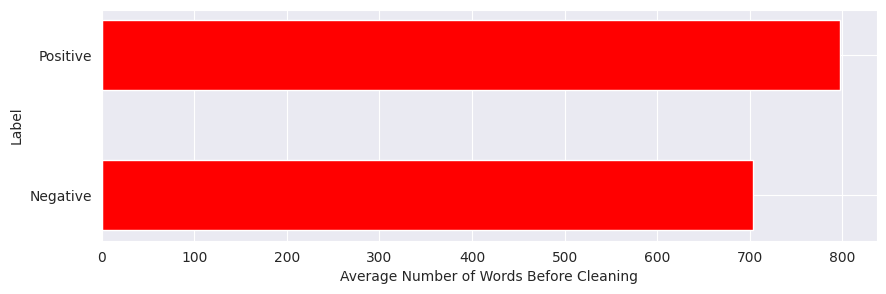

In [8]:
dataset.load()

dataset.info()

### Model Training (without data cleaning)
- Splits data into train/test sets (`stratify` enabled).
- Vectorize the input data to turn it into features.
- Trains the model using the training features and targets.

In [9]:
train_inputs, test_inputs, train_target, test_target = dataset.split()

train_features = model.vectorize(train_inputs, fit=True)
test_features = model.vectorize(test_inputs, fit=False)

model.fit(train_features, train_target)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: ismaelmousa (research-devellopment) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


### Displaying the Confusion Matrix
Visualizes the confusion matrix for the model's predictions on the test data, annotations: integer format (`fmt="d"`).

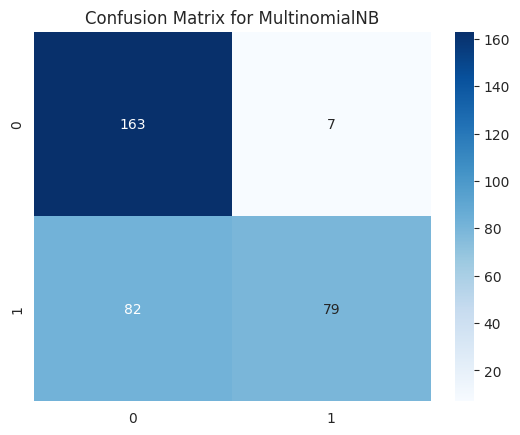

In [10]:
model.display_confusion_matrix(test_features, test_target)

### Model Performance Logging
- Tracks metrics in W&B and stores results in a DataFrame.
  - captures: train/test `loss`, `accuracy`, `F1`, `recall`, `precision`.
  - metadata: model/vectorizer types and hyperparameters.

In [11]:
train_results = model.evaluate(train_features, train_target)
test_results = model.evaluate(test_features, test_target)

model.log(train_results=train_results, test_results=test_results)

test_accuracy,▁
test_f1,▁
test_loss,▁
test_precision,▁
test_recall,▁
train_accuracy,▁
train_f1,▁
train_loss,▁
train_precision,▁
train_recall,▁
test_accuracy,0.7311


,model,vectorizer,train_loss,train_accuracy,train_f1,train_recall,train_precision,test_loss,test_accuracy,test_f1,test_recall,test_precision
0,MultinomialNB,TfidfVectorizer,0.3937,0.9418,0.9414,0.9404,0.9483,0.5518,0.7311,0.7126,0.7248,0.792


### Text Cleaning Pipeline
1. HTML Tag Removal: Uses `BeautifulSoup`.
2. Negation Normalization: Expands contractions (e.g., `"can't"` → `"can not"`).
3. Non-Alphanumeric Filtering: Regex-based cleanup.
4. Lowercasing, Stopword Removal, Lemmatization.
5. Label Conversion: Maps labels to numerical IDs.

Negatives :  848
Positives :  806

Common 20 Words After Cleaning:

Negatives          : ['not', 'film', 'movie', 'like', 'character', 'make', 'time', 'no', 'scene', 'good', 'play', 'look', 'bad', 'go', 'plot', 'story', 'know', 'get', 'come', 'think']

Positives          : ['film', 'not', 'movie', 'character', 'like', 'make', 'time', 'scene', 'story', 'good', 'life', 'play', 'no', 'way', 'come', 'year', 'end', 'know', 'go', 'work']

Commons (neg & pos): ['no', 'character', 'film', 'scene', 'not', 'good', 'make', 'come', 'story', 'play', 'movie', 'time', 'go', 'know', 'like']

Only Negatives     : {'bad', 'get', 'plot', 'look', 'think'}

Only Positives     : {'end', 'way', 'year', 'life', 'work'}


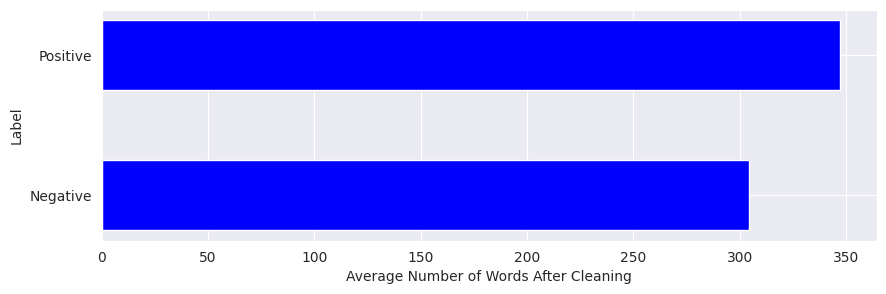

In [12]:
dataset.clean()

dataset.info(n=20)

### Model Training (with data cleaning)
- Splits data into train/test sets (`stratify` enabled).
- Vectorize the input data to turn it into features.
- Trains the model using the training features and targets.

In [13]:
train_inputs, test_inputs, train_target, test_target = dataset.split()

train_features = model.vectorize(train_inputs, fit=True)
test_features = model.vectorize(test_inputs, fit=False)

model.fit(train_features, train_target)

#### Notice there is an improvement on the performance `(TN: 158, TP: 93)` after cleaning.

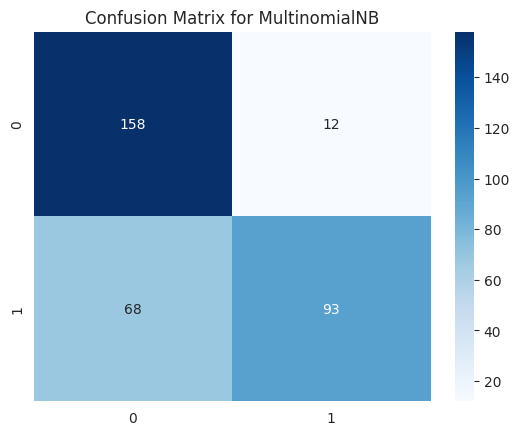

In [14]:
model.display_confusion_matrix(test_features, test_target)

In [15]:
train_results = model.evaluate(train_features, train_target)
test_results = model.evaluate(test_features,  test_target)

model.log(train_results=train_results, test_results=test_results)

test_accuracy,▁
test_f1,▁
test_loss,▁
test_precision,▁
test_recall,▁
train_accuracy,▁
train_f1,▁
train_loss,▁
train_precision,▁
train_recall,▁
test_accuracy,0.7583


,model,vectorizer,train_loss,train_accuracy,train_f1,train_recall,train_precision,test_loss,test_accuracy,test_f1,test_recall,test_precision
0,MultinomialNB,TfidfVectorizer,0.3937,0.9418,0.9414,0.9404,0.9483,0.5518,0.7311,0.7126,0.7248,0.7920
1,MultinomialNB,TfidfVectorizer,0.3512,0.9622,0.9621,0.9615,0.9643,0.5275,0.7583,0.7486,0.7535,0.7924


### Updating the Model Configuration (vectorizer)
Update the vectorizer `min_dif` and `max_df` hyperparameters.

After updating these configurations, the Model instance is reinitialized with the new settings, ensuring that the model uses the updated parameters for vectorization.

In [16]:
model_config.vectorizer_params = {"min_df": 6, "max_df": 0.7}

model = Model(model_config)

In [17]:
train_features = model.vectorize(train_inputs, fit=True)
test_features = model.vectorize(test_inputs, fit=False)

model.fit(train_features, train_target)

#### Notice there is an improvement on the performance `(TN: 159, TP: 115)`, after updating the vectorizer hyperparameters.

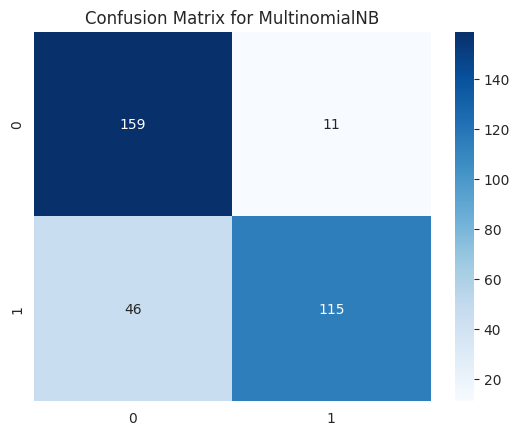

In [18]:
model.display_confusion_matrix(test_features, test_target)

In [19]:
train_results = model.evaluate(train_features, train_target)
test_results = model.evaluate(test_features, test_target)

model.log(train_results=train_results, test_results=test_results)

test_accuracy,▁
test_f1,▁
test_loss,▁
test_precision,▁
test_recall,▁
train_accuracy,▁
train_f1,▁
train_loss,▁
train_precision,▁
train_recall,▁
test_accuracy,0.8278


,model,vectorizer,train_loss,train_accuracy,train_f1,train_recall,train_precision,test_loss,test_accuracy,test_f1,test_recall,test_precision,min_df,max_df
0,MultinomialNB,TfidfVectorizer,0.3937,0.9418,0.9414,0.9404,0.9483,0.5518,0.7311,0.7126,0.7248,0.7920,NaN,NaN
1,MultinomialNB,TfidfVectorizer,0.3512,0.9622,0.9621,0.9615,0.9643,0.5275,0.7583,0.7486,0.7535,0.7924,NaN,NaN
2,MultinomialNB,TfidfVectorizer,0.3757,0.9456,0.9454,0.9449,0.9472,0.5057,0.8278,0.8247,0.8248,0.8442,6.0,0.7


### Updating the Model Configuration (model)
The model is set to RandomForestClassifier, and the model parameters are updated in the model configurations.

In [20]:
model_config.model_params = {"random_state": 42}
model_config.model = RandomForestClassifier()

model = Model(model_config)

model.fit(train_features, train_target)

#### Notice there is a decline in the performance `(TN: 151, TP: 116)`, after setting the model to RandomForestClassifier.

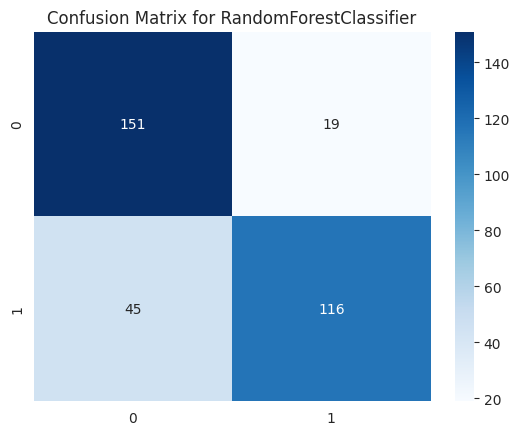

In [21]:
model.display_confusion_matrix(test_features, test_target)

In [22]:
train_results = model.evaluate(train_features, train_target)
test_results = model.evaluate(test_features, test_target)

model.log(train_results=train_results, test_results=test_results)

test_accuracy,▁
test_f1,▁
test_loss,▁
test_precision,▁
test_recall,▁
train_accuracy,▁
train_f1,▁
train_loss,▁
train_precision,▁
train_recall,▁
test_accuracy,0.8066


,model,vectorizer,train_loss,train_accuracy,train_f1,train_recall,train_precision,test_loss,test_accuracy,test_f1,test_recall,test_precision,min_df,max_df,random_state
0,MultinomialNB,TfidfVectorizer,0.3937,0.9418,0.9414,0.9404,0.9483,0.5518,0.7311,0.7126,0.7248,0.7920,NaN,NaN,NaN
1,MultinomialNB,TfidfVectorizer,0.3512,0.9622,0.9621,0.9615,0.9643,0.5275,0.7583,0.7486,0.7535,0.7924,NaN,NaN,NaN
2,MultinomialNB,TfidfVectorizer,0.3757,0.9456,0.9454,0.9449,0.9472,0.5057,0.8278,0.8247,0.8248,0.8442,6.0,0.7,NaN
3,RandomForestClassifier,TfidfVectorizer,0.1672,1.0000,1.0000,1.0000,1.0000,0.5392,0.8066,0.8045,0.8044,0.8148,6.0,0.7,42.0


### Updating the Model Configuration (vectorizer)
Update the vectorizer `max_features` hyperparameters.

After updating these configurations, the Model instance is reinitialized with the new settings, ensuring that the model uses the updated parameters for vectorization.

In [23]:
model_config.vectorizer_params.update({"max_features": 3000})

model = Model(model_config)

train_features = model.vectorize(train_inputs, fit=True)
test_features = model.vectorize(test_inputs, fit=False)

model.fit(train_features, train_target)

#### Notice there is a decline in the performance `(TN: 155, TP: 109)`, after updating the vectorizer hyperparameters.

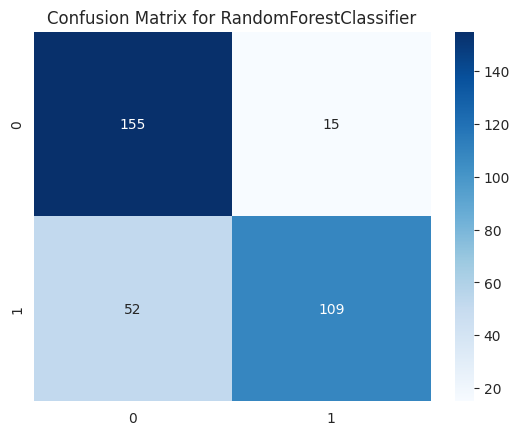

In [24]:
model.display_confusion_matrix(test_features, test_target)

In [25]:
train_results = model.evaluate(train_features, train_target)
test_results = model.evaluate(test_features, test_target)

model.log(train_results=train_results, test_results=test_results)

test_accuracy,▁
test_f1,▁
test_loss,▁
test_precision,▁
test_recall,▁
train_accuracy,▁
train_f1,▁
train_loss,▁
train_precision,▁
train_recall,▁
test_accuracy,0.7976


,model,vectorizer,train_loss,train_accuracy,train_f1,train_recall,train_precision,test_loss,test_accuracy,test_f1,test_recall,test_precision,min_df,max_df,random_state,max_features
0,MultinomialNB,TfidfVectorizer,0.3937,0.9418,0.9414,0.9404,0.9483,0.5518,0.7311,0.7126,0.7248,0.7920,NaN,NaN,NaN,NaN
1,MultinomialNB,TfidfVectorizer,0.3512,0.9622,0.9621,0.9615,0.9643,0.5275,0.7583,0.7486,0.7535,0.7924,NaN,NaN,NaN,NaN
2,MultinomialNB,TfidfVectorizer,0.3757,0.9456,0.9454,0.9449,0.9472,0.5057,0.8278,0.8247,0.8248,0.8442,6.0,0.7,NaN,NaN
3,RandomForestClassifier,TfidfVectorizer,0.1672,1.0000,1.0000,1.0000,1.0000,0.5392,0.8066,0.8045,0.8044,0.8148,6.0,0.7,42.0,NaN
4,RandomForestClassifier,TfidfVectorizer,0.1659,1.0000,1.0000,1.0000,1.0000,0.5354,0.7976,0.7936,0.7944,0.8139,6.0,0.7,42.0,3000.0


### Updating the Model Configuration (model and vectorizer)
Update the vectorizer `ngram_range` hyperparameters.

Update the model `n_estimators`, `max_depth`, `min_samples_leaf`, and `min_samples_split` hyperparameters.

After updating these configurations, the Model instance is reinitialized with the new settings, ensuring that the model uses the updated parameters for vectorization and model.

In [26]:
model_config.vectorizer_params.update({"ngram_range": (1, 2)})
model_config.model_params.update({"n_estimators": 50, "max_depth": 5, "min_samples_leaf": 5, "min_samples_split": 3})

model = Model(model_config)

train_features = model.vectorize(train_inputs, fit=True)
test_features = model.vectorize(test_inputs, fit=False)

model.fit(train_features, train_target)

#### Notice there is a decline in the performance `(TN: 148, TP: 109)`, after updating the vectorizer and model hyperparameters.

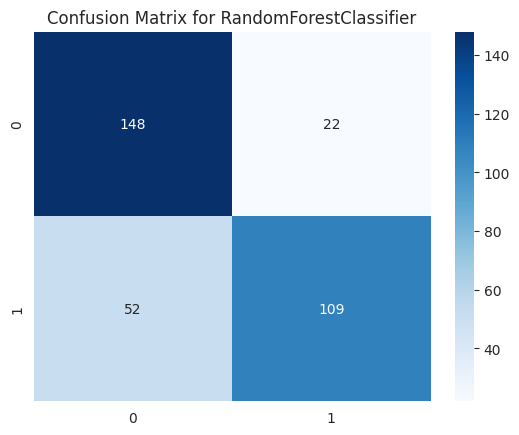

In [27]:
model.display_confusion_matrix(test_features, test_target)

In [28]:
train_results = model.evaluate(train_features, train_target)
test_results = model.evaluate(test_features, test_target)

model.log(train_results=train_results, test_results=test_results)

test_accuracy,▁
test_f1,▁
test_loss,▁
test_precision,▁
test_recall,▁
train_accuracy,▁
train_f1,▁
train_loss,▁
train_precision,▁
train_recall,▁
test_accuracy,0.7764


,model,vectorizer,train_loss,train_accuracy,train_f1,train_recall,train_precision,test_loss,test_accuracy,test_f1,...,test_precision,min_df,max_df,random_state,max_features,n_estimators,max_depth,min_samples_leaf,min_samples_split,ngram_range
0,MultinomialNB,TfidfVectorizer,0.3937,0.9418,0.9414,0.9404,0.9483,0.5518,0.7311,0.7126,...,0.7920,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,MultinomialNB,TfidfVectorizer,0.3512,0.9622,0.9621,0.9615,0.9643,0.5275,0.7583,0.7486,...,0.7924,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,MultinomialNB,TfidfVectorizer,0.3757,0.9456,0.9454,0.9449,0.9472,0.5057,0.8278,0.8247,...,0.8442,6.0,0.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,RandomForestClassifier,TfidfVectorizer,0.1672,1.0000,1.0000,1.0000,1.0000,0.5392,0.8066,0.8045,...,0.8148,6.0,0.7,42.0,NaN,NaN,NaN,NaN,NaN,NaN
4,RandomForestClassifier,TfidfVectorizer,0.1659,1.0000,1.0000,1.0000,1.0000,0.5354,0.7976,0.7936,...,0.8139,6.0,0.7,42.0,3000.0,NaN,NaN,NaN,NaN,NaN
5,RandomForestClassifier,TfidfVectorizer,0.5767,0.8851,0.8850,0.8850,0.8851,0.6204,0.7764,0.7733,...,0.7860,6.0,0.7,42.0,3000.0,50.0,5.0,5.0,3.0,"(1, 2)"


#### Let's take the advantage of the `commons` words between the documents.

In [29]:
top_negatives, top_positives, commons, only_negatives, only_positives =  dataset.count(n=20)

print(top_negatives, top_positives, commons, only_negatives, only_positives, sep="\n")

['not', 'film', 'movie', 'like', 'character', 'make', 'time', 'no', 'scene', 'good', 'play', 'look', 'bad', 'go', 'plot', 'story', 'know', 'get', 'come', 'think']
['film', 'not', 'movie', 'character', 'like', 'make', 'time', 'scene', 'story', 'good', 'life', 'play', 'no', 'way', 'come', 'year', 'end', 'know', 'go', 'work']
['no', 'character', 'film', 'scene', 'not', 'good', 'make', 'come', 'story', 'play', 'movie', 'time', 'go', 'know', 'like']
{'bad', 'get', 'plot', 'look', 'think'}
{'end', 'way', 'year', 'life', 'work'}


### Updating the Model Configuration (vectorizer)
Update the vectorizer `stop_words` hyperparameters, where pass the `commons` words as a stopwords to the vectorizer, so it will exclude them from the feature set.

After updating these configurations, the Model instance is reinitialized with the new settings, ensuring that the model uses the updated parameters for vectorization.

In [30]:
model_config.vectorizer_params.update({"stop_words": commons})

model = Model(model_config)

train_features = model.vectorize(train_inputs, fit=True)
test_features = model.vectorize(test_inputs, fit=False)

model.fit(train_features, train_target)

#### Notice there is an improvements in the performance `(TN: 151, TP: 111)`, after updating the vectorizer hyperparameters.

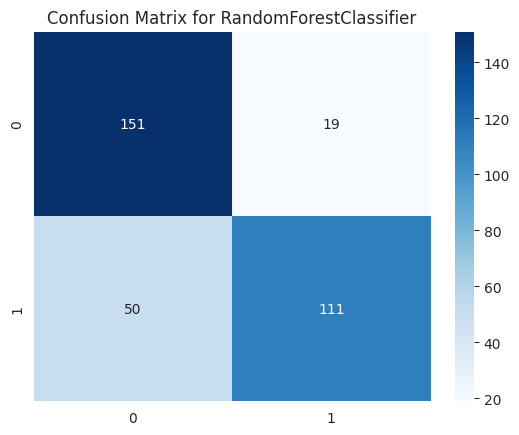

In [31]:
model.display_confusion_matrix(test_features, test_target)

In [ ]:
train_results = model.evaluate(train_features, train_target)
test_results = model.evaluate(test_features, test_target)

model.log(train_results=train_results, test_results=test_results)

### Updating the Model Configuration (model)
The model is set to LogisticRegression, and the model parameters are updated in the model configurations.

After updating these configurations, the Model instance is reinitialized with the new settings, ensuring that the model uses the updated parameters for model.

In [33]:
model_config.model_params = {"random_state": 42, "max_iter": 1000}
model_config.model = LogisticRegression()

model = Model(model_config)

train_features = model.vectorize(train_inputs, fit=True)
test_features = model.vectorize(test_inputs, fit=False)

model.fit(train_features, train_target)

### Here is the Features That Have the Most Impact on the Sentiment

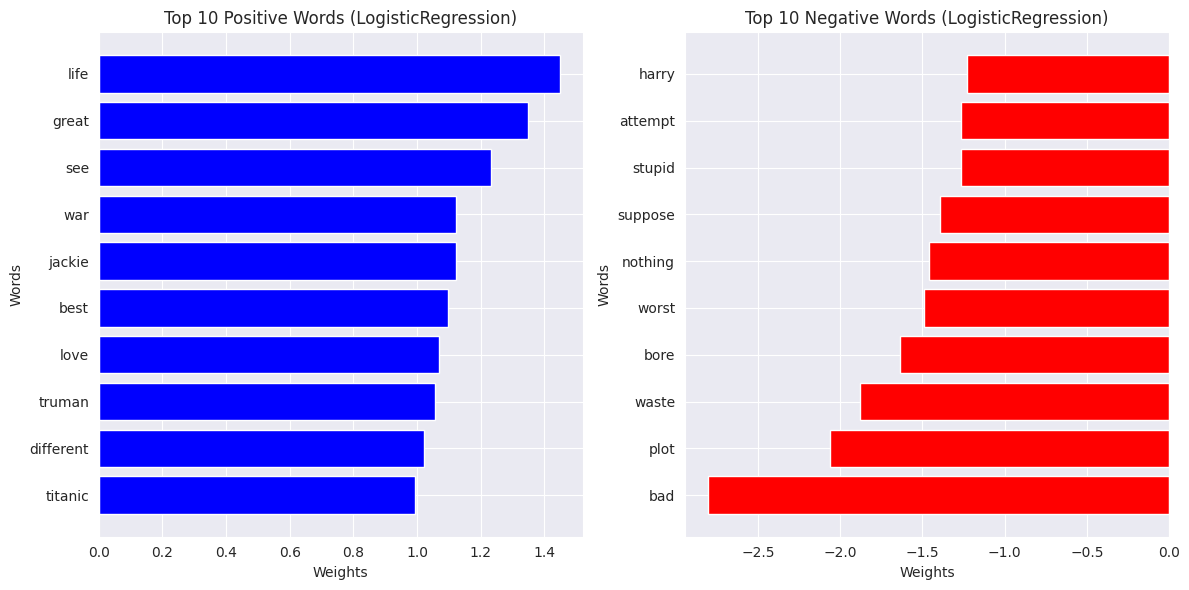

In [34]:
model.display_top_influences()

#### Notice there is a huge improvements in the performance `(TN: 155, TP: 136)`, after setting the model to LogisticRegression.

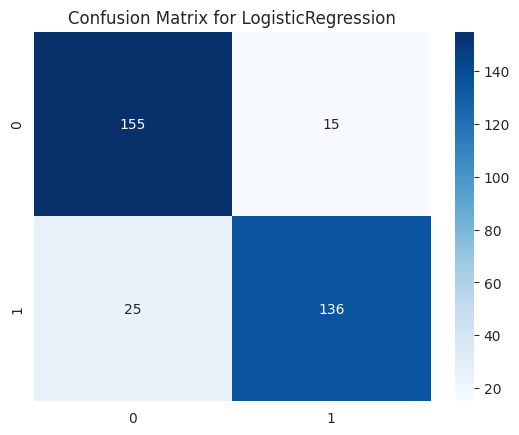

In [35]:
model.display_confusion_matrix(test_features, test_target)

In [36]:
train_results = model.evaluate(train_features, train_target)
test_results = model.evaluate(test_features, test_target)

model.log(train_results=train_results, test_results=test_results)

test_accuracy,▁
test_f1,▁
test_loss,▁
test_precision,▁
test_recall,▁
train_accuracy,▁
train_f1,▁
train_loss,▁
train_precision,▁
train_recall,▁
test_accuracy,0.8792


,model,vectorizer,train_loss,train_accuracy,train_f1,train_recall,train_precision,test_loss,test_accuracy,test_f1,...,max_df,random_state,max_features,n_estimators,max_depth,min_samples_leaf,min_samples_split,ngram_range,stop_words,max_iter
0,MultinomialNB,TfidfVectorizer,0.3937,0.9418,0.9414,0.9404,0.9483,0.5518,0.7311,0.7126,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,MultinomialNB,TfidfVectorizer,0.3512,0.9622,0.9621,0.9615,0.9643,0.5275,0.7583,0.7486,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,MultinomialNB,TfidfVectorizer,0.3757,0.9456,0.9454,0.9449,0.9472,0.5057,0.8278,0.8247,...,0.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,RandomForestClassifier,TfidfVectorizer,0.1672,1.0000,1.0000,1.0000,1.0000,0.5392,0.8066,0.8045,...,0.7,42.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,RandomForestClassifier,TfidfVectorizer,0.1659,1.0000,1.0000,1.0000,1.0000,0.5354,0.7976,0.7936,...,0.7,42.0,3000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,RandomForestClassifier,TfidfVectorizer,0.5767,0.8851,0.8850,0.8850,0.8851,0.6204,0.7764,0.7733,...,0.7,42.0,3000.0,50.0,5.0,5.0,3.0,"(1, 2)",NaN,NaN
6,RandomForestClassifier,TfidfVectorizer,0.5799,0.9048,0.9045,0.9041,0.9060,0.6247,0.7915,0.7885,...,0.7,42.0,3000.0,50.0,5.0,5.0,3.0,"(1, 2)","[no, character, film, scene, not, good, make, ...",NaN
7,LogisticRegression,TfidfVectorizer,0.4122,0.9599,0.9599,0.9598,0.9601,0.4942,0.8792,0.8788,...,0.7,42.0,3000.0,NaN,NaN,NaN,NaN,"(1, 2)","[no, character, film, scene, not, good, make, ...",1000.0


### Updating the Model Configuration (vectorizer)
Update the vectorizer `stop_words` hyperparameters where ignore removing `commons` from the feature set, so the `commons` will be included in the feature set.

After updating these configurations, the Model instance is reinitialized with the new settings, ensuring that the model uses the updated parameters for vectorization.

In [37]:
model_config.vectorizer_params.update({"stop_words": None})

model = Model(model_config)

train_features = model.vectorize(train_inputs, fit=True)
test_features = model.vectorize(test_inputs, fit=False)

model.fit(train_features, train_target)

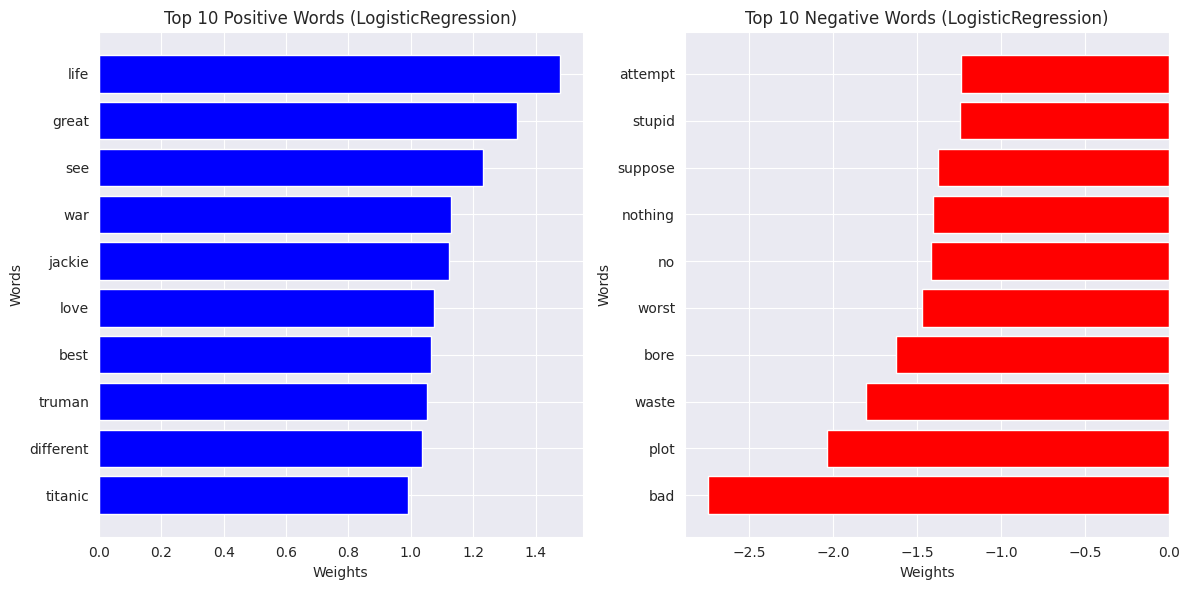

In [38]:
model.display_top_influences()

#### From our experiments, this is the best result we obtained: `(TN: 155, TP: 137)`.

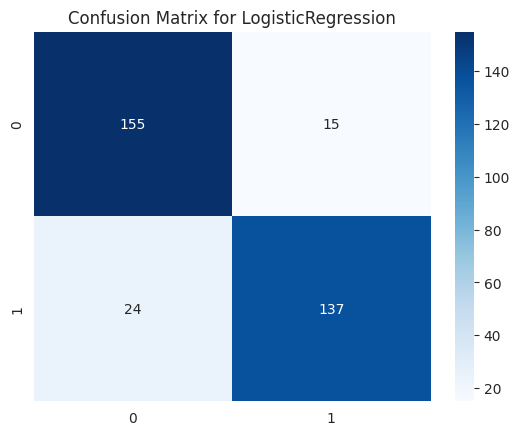

In [39]:
model.display_confusion_matrix(test_features, test_target)

In [40]:
train_results = model.evaluate(train_features, train_target)
test_results = model.evaluate(test_features, test_target)

model.log(train_results=train_results, test_results=test_results)

test_accuracy,▁
test_f1,▁
test_loss,▁
test_precision,▁
test_recall,▁
train_accuracy,▁
train_f1,▁
train_loss,▁
train_precision,▁
train_recall,▁
test_accuracy,0.8822


,model,vectorizer,train_loss,train_accuracy,train_f1,train_recall,train_precision,test_loss,test_accuracy,test_f1,...,max_df,random_state,max_features,n_estimators,max_depth,min_samples_leaf,min_samples_split,ngram_range,stop_words,max_iter
0,MultinomialNB,TfidfVectorizer,0.3937,0.9418,0.9414,0.9404,0.9483,0.5518,0.7311,0.7126,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,MultinomialNB,TfidfVectorizer,0.3512,0.9622,0.9621,0.9615,0.9643,0.5275,0.7583,0.7486,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,MultinomialNB,TfidfVectorizer,0.3757,0.9456,0.9454,0.9449,0.9472,0.5057,0.8278,0.8247,...,0.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,RandomForestClassifier,TfidfVectorizer,0.1672,1.0000,1.0000,1.0000,1.0000,0.5392,0.8066,0.8045,...,0.7,42.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,RandomForestClassifier,TfidfVectorizer,0.1659,1.0000,1.0000,1.0000,1.0000,0.5354,0.7976,0.7936,...,0.7,42.0,3000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,RandomForestClassifier,TfidfVectorizer,0.5767,0.8851,0.8850,0.8850,0.8851,0.6204,0.7764,0.7733,...,0.7,42.0,3000.0,50.0,5.0,5.0,3.0,"(1, 2)",NaN,NaN
6,RandomForestClassifier,TfidfVectorizer,0.5799,0.9048,0.9045,0.9041,0.9060,0.6247,0.7915,0.7885,...,0.7,42.0,3000.0,50.0,5.0,5.0,3.0,"(1, 2)","[no, character, film, scene, not, good, make, ...",NaN
7,LogisticRegression,TfidfVectorizer,0.4122,0.9599,0.9599,0.9598,0.9601,0.4942,0.8792,0.8788,...,0.7,42.0,3000.0,NaN,NaN,NaN,NaN,"(1, 2)","[no, character, film, scene, not, good, make, ...",1000.0
8,LogisticRegression,TfidfVectorizer,0.4100,0.9599,0.9599,0.9599,0.9600,0.4903,0.8822,0.8818,...,0.7,42.0,3000.0,NaN,NaN,NaN,NaN,"(1, 2)",None,1000.0


## All Experiments are Tracked and Documented in [W&B Report](https://api.wandb.ai/links/research-devellopment/hjgmo1ka)

## Inference

Here in `type`, insert the name of the folders that contains the `neg` & `pos` folders, and enjoy with your testing.

In [48]:
dataset_config = DatasetConfig(type="testing")
dataset = Dataset(dataset_config)

dataset.load()
dataset.clean()

inputs, target = dataset.read["text"], dataset.read["label"]

features = model.vectorize(inputs, fit=False)

print(f"Loss, Accuracy, F1, Recall, Precision: {model.evaluate(features, target)}")